In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import os
import shap
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline

from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import missingno as msno
from scipy import interpolate
import numpy as np

   WELLNUM       DEPTH     DTC     DTS      BS    CALI     DEN    DENC  \
0        0  335.160105 -9999.0 -9999.0 -9999.0 -9999.0 -9999.0 -9999.0   
1        0  335.660105 -9999.0 -9999.0 -9999.0 -9999.0 -9999.0 -9999.0   
2        0  336.160105 -9999.0 -9999.0 -9999.0 -9999.0 -9999.0 -9999.0   
3        0  336.660105 -9999.0 -9999.0 -9999.0 -9999.0 -9999.0 -9999.0   
4        0  337.160105 -9999.0 -9999.0 -9999.0 -9999.0 -9999.0 -9999.0   

       GR     NEU     PEF    RDEP    RMED     ROP    PHIF      SW     VSH  
0  5.3274 -9999.0 -9999.0 -9999.0 -9999.0 -9999.0 -9999.0 -9999.0 -9999.0  
1  5.8235 -9999.0 -9999.0 -9999.0 -9999.0 -9999.0 -9999.0 -9999.0 -9999.0  
2  6.5228 -9999.0 -9999.0 -9999.0 -9999.0 -9999.0 -9999.0 -9999.0 -9999.0  
3  7.2285 -9999.0 -9999.0 -9999.0 -9999.0 -9999.0 -9999.0 -9999.0 -9999.0  
4  9.5020 -9999.0 -9999.0 -9999.0 -9999.0 -9999.0 -9999.0 -9999.0 -9999.0  
   WELLNUM       DEPTH     DTC     DTS     DEN      GR     NEU     PEF  \
0        0  335.160105 -9

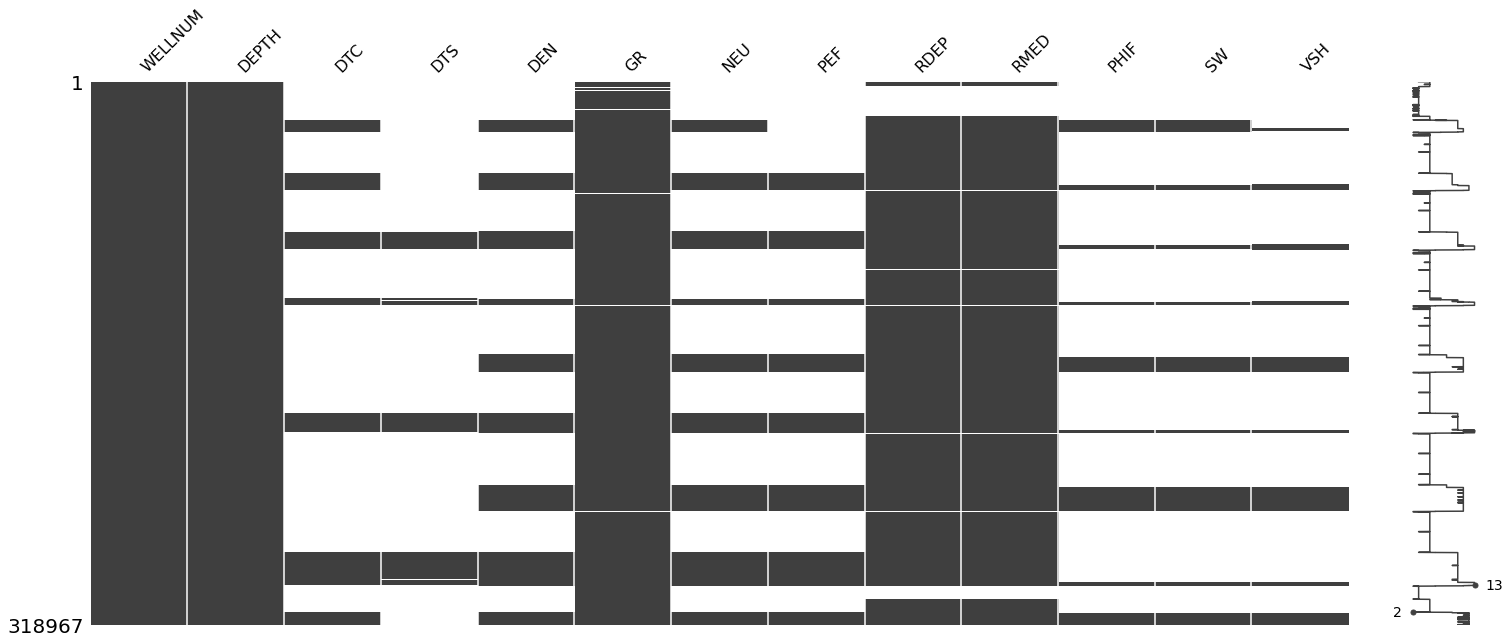

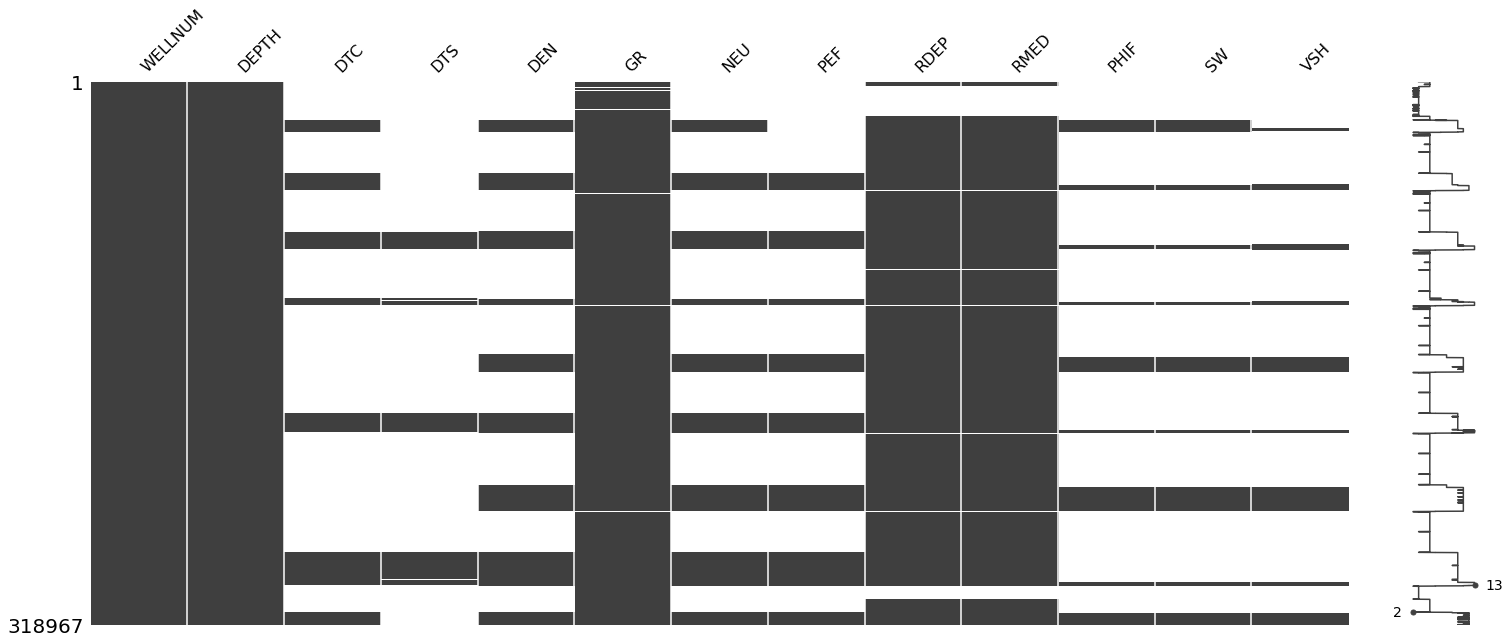

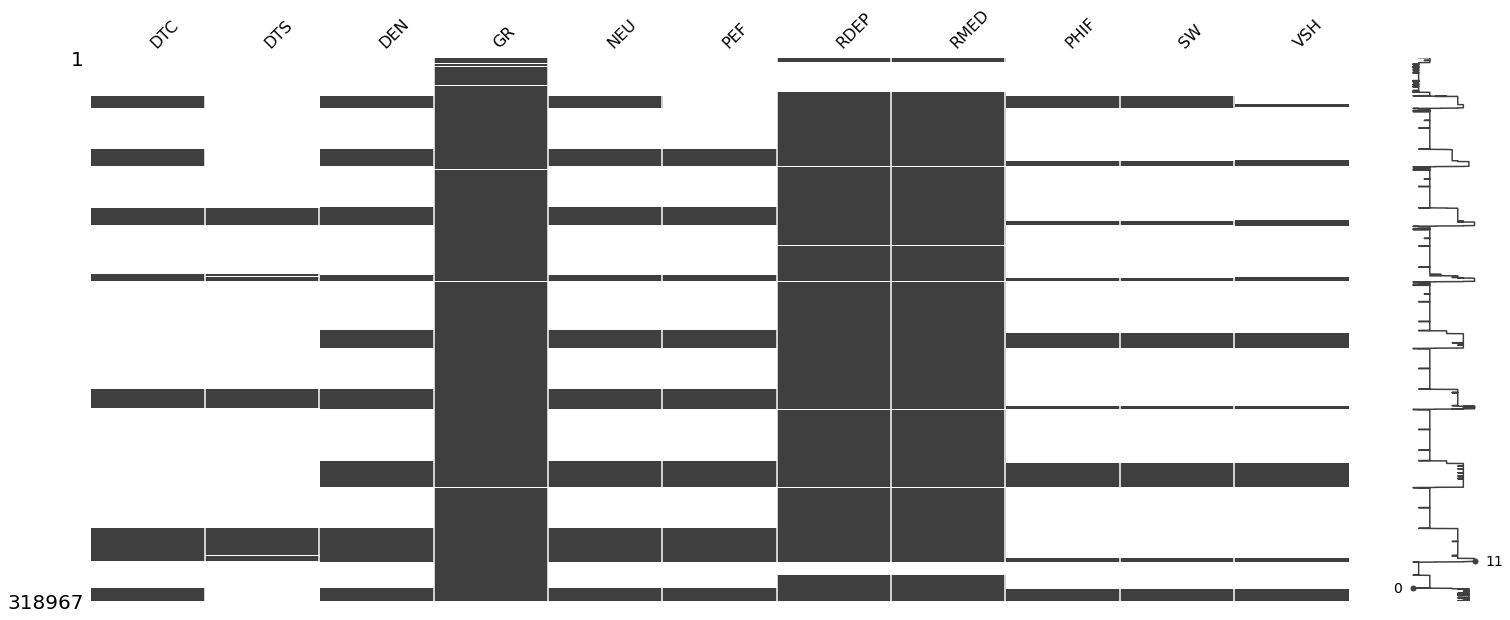

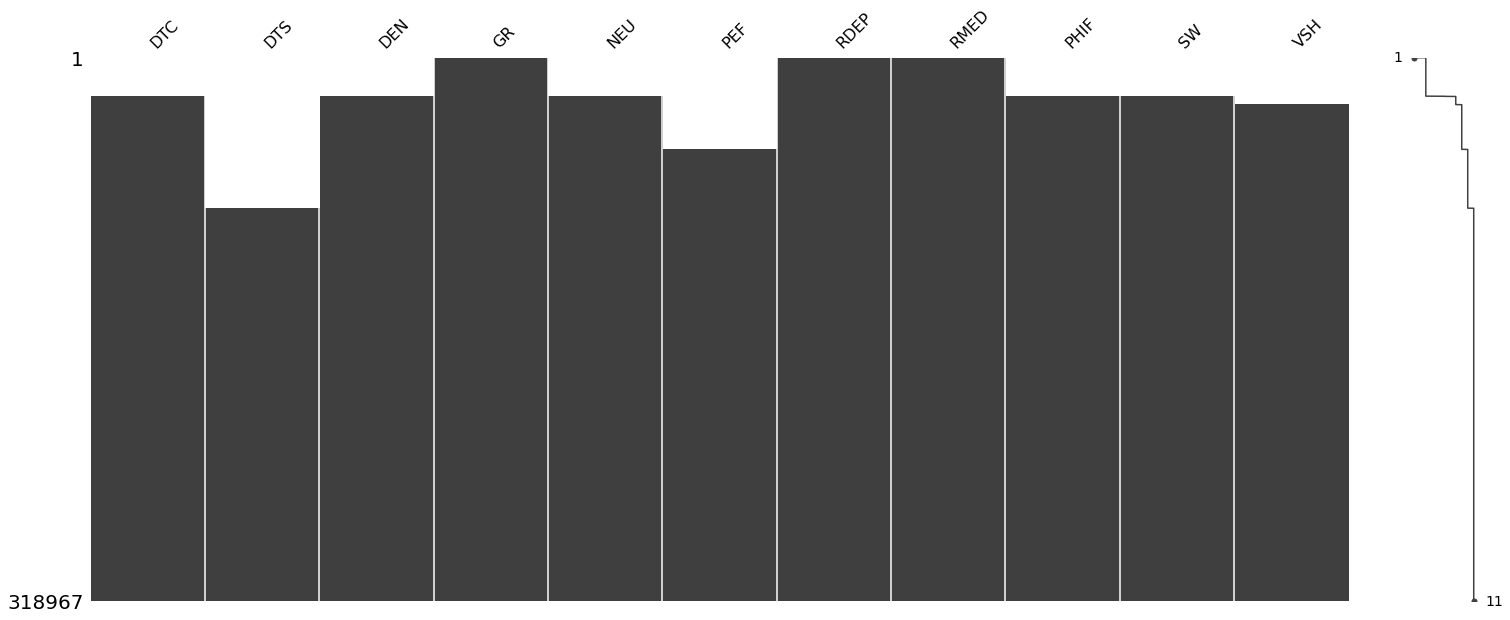

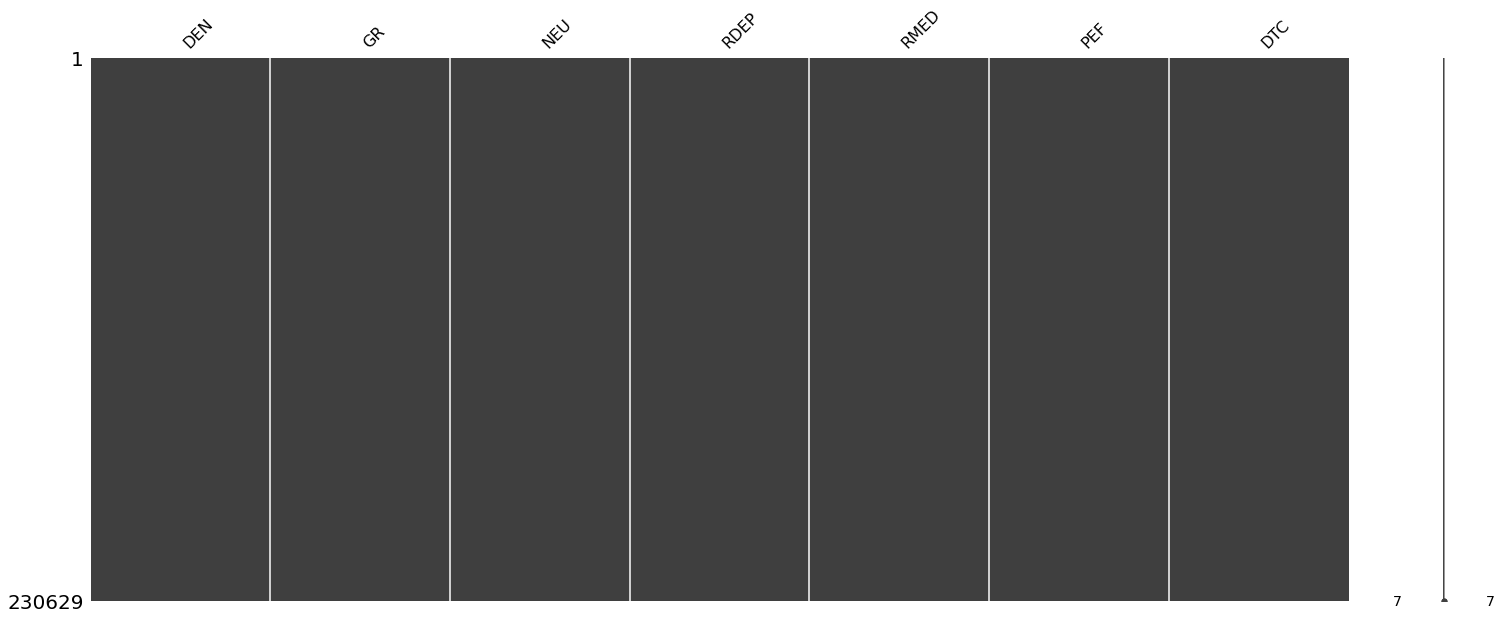

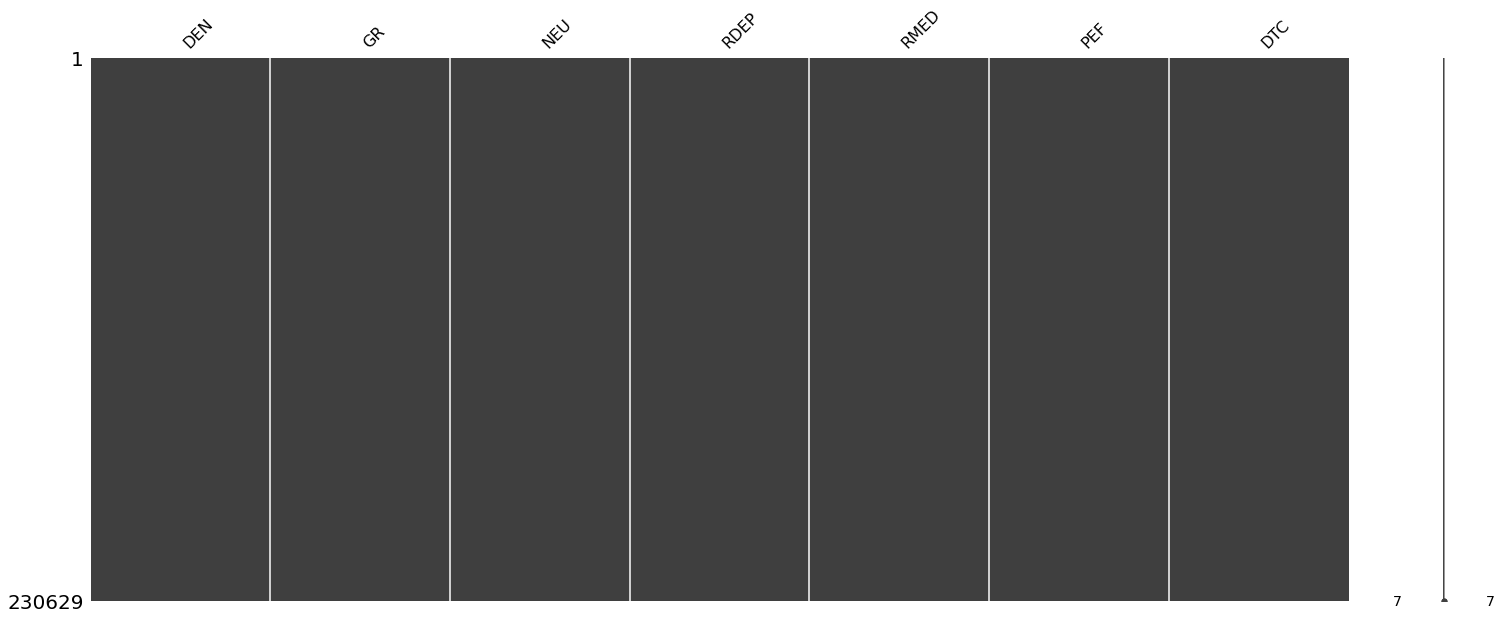

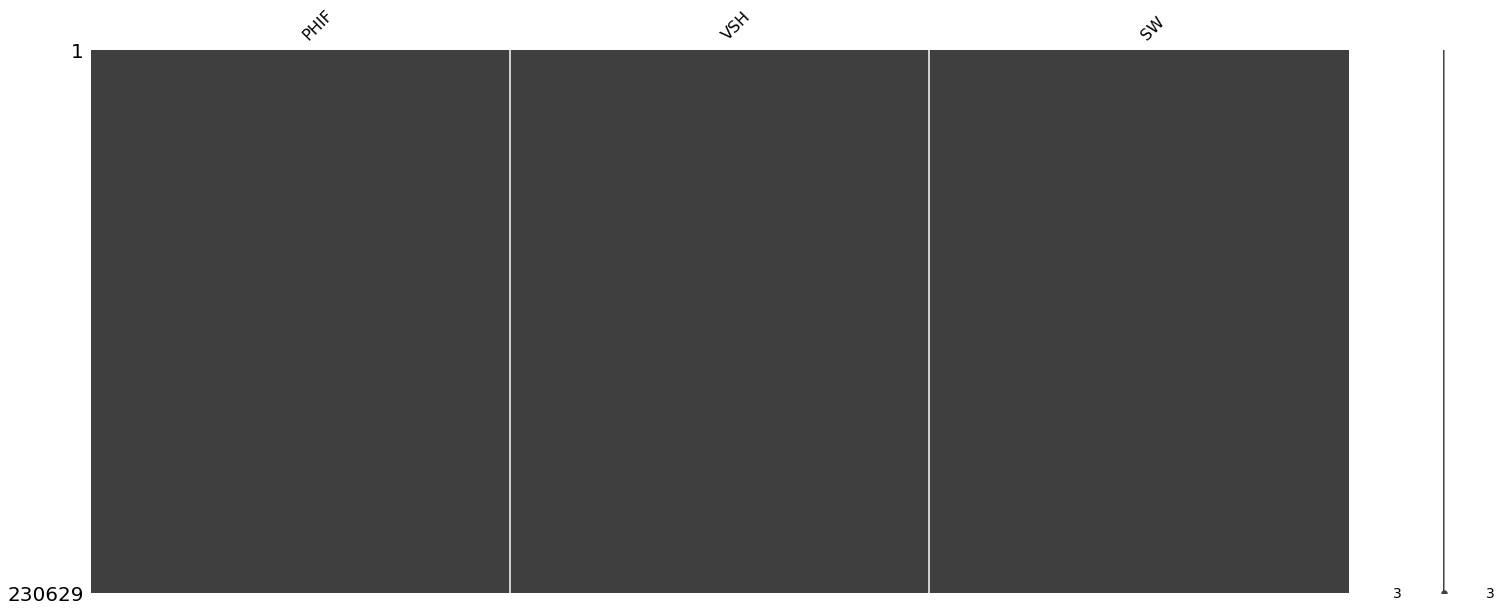

In [2]:
#Load dataset file
train_path = r"/Users/astromeria/Documents/SPWLA_competition/data/train.csv"
train_data = pd.read_csv(train_path)

logs_discarded = ["BS", "CALI", "DENC", "ROP"]
targets = ['PHIF', 'VSH', 'SW']
print(train_data.head())
#drop irrelevant columns
train_data = train_data.drop(columns=logs_discarded)
print(train_data.head())

#convert -9999 values to NaN
train_data = train_data.mask(train_data == -9999.0, np.nan)
msno.matrix(train_data)
print(train_data.head())

discarded =  ["WELLNUM", "DEPTH"]
targets = ['PHIF', 'VSH', 'SW']
features = ["DEN","GR","NEU", "RDEP","RMED", "PEF", "DTC"]
msno.matrix(train_data)
train_data = train_data.drop(columns=discarded)



#train_data = train_data.sample(n=1000,replace=False)
print(len(train_data))

msno.matrix(train_data)
train_data = train_data.interpolate()
msno.matrix(train_data)

pef_mean = np.mean(train_data["PEF"])
print(pef_mean)
train_data['PEF'] = train_data['PEF'].fillna(pef_mean)

pef_mean = np.mean(train_data["DEN"])
print(pef_mean)
train_data['DEN'] = train_data['DEN'].fillna(pef_mean)

pef_mean = np.mean(train_data["NEU"])
print(pef_mean)
train_data['NEU'] = train_data['NEU'].fillna(pef_mean)

pef_mean = np.mean(train_data["DTC"])
print(pef_mean)
train_data['DTC'] = train_data['DTC'].fillna(pef_mean)

pef_mean = np.mean(train_data["SW"])
print(pef_mean)
train_data['SW'] = train_data['SW'].fillna(pef_mean)

pef_mean = np.mean(train_data["VSH"])
print(pef_mean)
train_data['VSH'] = train_data['VSH'].fillna(pef_mean)

pef_mean = np.mean(train_data["PHIF"])
print(pef_mean)
train_data['PHIF'] = train_data['PHIF'].fillna(pef_mean)

train_data = train_data.dropna()
#separate in x (inputs) and y(targets or outputs)
x_train = train_data.loc[:, features]
y_train = train_data.loc[:, targets]
msno.matrix(x_train)


#pef_mean = np.mean(x_train["DTS"])
#print(pef_mean)
#x_train['DTS'] = x_train['DTS'].fillna(pef_mean)
msno.matrix(x_train)
msno.matrix(y_train)

#adjust values of targets:
#SW 0-1
#0<PHIF
# 0<VSH 
print(y_train.describe())
#y_train.loc[y_train["SW"] < 0, "SW"] = 0
#y_train.loc[y_train["SW"] > 1, "SW"] = 1
#y_train.loc[y_train["PHIF"] < 0, "PHIF"] = 0
#y_train.loc[y_train["PHIF"] > 1, "PHIF"] = 1



x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.15)

#Normalize data
sc = StandardScaler()
x_train = pd.DataFrame(sc.fit_transform(x_train))
x_test = pd.DataFrame(sc.transform(x_test))


In [3]:
#training history plotting function
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Squared Error ')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0,1])
  plt.legend()

 
  plt.show()

In [4]:
#model
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(x_train.keys())]),
    layers.Dropout(0.1),
   
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.1),
    
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.1),
   
    
    layers.Dense(len(y_train.keys()))
  ])
  optimizer = tf.keras.optimizers.Adam(0.001)
  model.compile(loss="mse",
                optimizer=optimizer,
                metrics=[ tf.keras.metrics.RootMeanSquaredError()])
  return model

#create a model instance
checkpoint_path = r"/Users/astromeria/Documents/SPWLA_competition/weights/26Jan.h5"
checkpoint = keras.callbacks.ModelCheckpoint( checkpoint_path, save_best_only=True, monitor = "val_loss")
model = build_model()

history = model.fit(
  x_train, y_train,
  epochs=150, validation_split = 0.1, verbose=2, callbacks = checkpoint)#just 10% for validation to use most of the data on training
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()
#plot_history(history)

2022-02-01 19:51:29.939659: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-01 19:51:30.014872: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


Epoch 1/150
5514/5514 - 4s - loss: 0.0154 - root_mean_squared_error: 0.1239 - val_loss: 0.0042 - val_root_mean_squared_error: 0.0647
Epoch 2/150
5514/5514 - 3s - loss: 0.0055 - root_mean_squared_error: 0.0745 - val_loss: 0.0031 - val_root_mean_squared_error: 0.0557
Epoch 3/150
5514/5514 - 3s - loss: 0.0045 - root_mean_squared_error: 0.0669 - val_loss: 0.0028 - val_root_mean_squared_error: 0.0529
Epoch 4/150
5514/5514 - 3s - loss: 0.0038 - root_mean_squared_error: 0.0615 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0456
Epoch 5/150
5514/5514 - 3s - loss: 0.0035 - root_mean_squared_error: 0.0591 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0446
Epoch 6/150
5514/5514 - 3s - loss: 0.0033 - root_mean_squared_error: 0.0573 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0446
Epoch 7/150
5514/5514 - 3s - loss: 0.0031 - root_mean_squared_error: 0.0557 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0434
Epoch 8/150
5514/5514 - 3s - loss: 0.0030 - root_mean_squared_error: 

KeyboardInterrupt: 

In [ ]:
model.load_weights(checkpoint_path)

loss, mse = model.evaluate(x_test, y_test, verbose=2)
test_predictions = model.predict(x_test)
print(y_test.head)

col_names_y = [ "PHIF","VSH", "SW"]
plt.scatter(y_test["PHIF"], test_predictions[:,0], color = "blue", label = col_names_y[0], alpha=0.2)
plt.scatter(y_test["VSH"], test_predictions[:,1], color = "green", label = col_names_y[1], alpha=0.2)
plt.scatter(y_test["SW"], test_predictions[:,2], color = "orange", label = col_names_y[2],alpha=0.2)



           
plt.xlabel('True Values ')
plt.ylabel('Predictions ')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
plt.legend()
_ = plt.plot([-100, 100], [-100, 100])
plt.show()


error = test_predictions - np.asarray(y_test)
plt.hist(error[:,2] , color="orange", label = col_names_y[2])
plt.hist(error[:,0], color = "green", label = col_names_y[0])
plt.hist(error[:,1],  color="blue", label = col_names_y[1])

plt.legend()
plt.xlabel("Prediction Error")
_ = plt.ylabel("Count")